# Bow-Task Model
This is just for you to see how the model was implemented.


In [1]:
# --- SETUP ---
import kagglehub
import nltk
import re
from collections import Counter
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics import classification_report
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

plt.style.use('ggplot')
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)

# --- DATA ---
DATA_PATH = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

df = pd.read_csv(DATA_PATH + '/twitter_training.csv', header=None, names=['tweet_id', 'entity', 'label', 'tweet'])
val_df = pd.read_csv(DATA_PATH + '/twitter_validation.csv', header=None, names=['tweet_id', 'entity', 'label', 'tweet'])

print(df.sample(3))
print(df['label'].value_counts())

/home/fabian/miniconda3/envs/xai/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/fabian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fabian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/fabian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/fabian/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/fabian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Running on: cuda
       tweet_id                entity     label  \
16420      9612     PlayStation5(PS5)  Positive   
57896     11528  TomClancysRainbowSix   Neutral   
28075       433           ApexLegends  Negative   

                                                   tweet  
16420  Next gen consoles bout to have some other grea...  
57896  Yo we are now live on Festival!!!!!!!!!!!!!!!!...  
28075  It is not the first time that the EU Commissio...  
label
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


In [2]:
# --- TEXT CLEANING HELPERS ---
def special_and_lower(text):
    return re.sub('[^0-9a-zA-Z ]+', '', text).lower()

def tokenize_text(text):
    return word_tokenize(text)

lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    out = [lemmatizer.lemmatize(w, pos='v') for w in tokens]
    out = [lemmatizer.lemmatize(w, pos='n') for w in out]
    return out

def replace_numbers(tokens):
    return [re.sub(r'\d+', '<NUM>', w) for w in tokens]

stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [w for w in tokens if w not in stop_words]

def preprocess_text(text):
    # handle NaN or non-string inputs
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)

    text = special_and_lower(text)
    text = tokenize_text(text)
    text = lemmatize_text(text)
    text = replace_numbers(text)
    text = remove_stopwords(text)
    return text


# --- TEST SAMPLE ---
test_corpus_df = val_df.sample(3, random_state=42)
test_corpus = test_corpus_df['tweet'].tolist()
test_corpus = [preprocess_text(t) for t in test_corpus]
print(test_corpus)

# --- VOCABULARY ---
def build_vocab(corpus):
    all_tokens = [t for tweet in corpus for t in tweet]
    unique_tokens = sorted(set(all_tokens))
    vocab = {tok: i for i, tok in enumerate(unique_tokens)}
    return vocab

def build_index2token(vocab):
    return {v: k for k, v in vocab.items()}

vocab = build_vocab(test_corpus)
index2token = build_index2token(vocab)

print("Sample vocab:", list(vocab.items())[:10])

[['remote', 'work', 'increase', 'cloudbased', 'data', 'spur', 'cyberattacks', 'today', 'see', 'publication', 'verizon', 'business', '<NUM>', 'data', 'breach', 'investigation', 'report', 'show', 'network', 'security', 'even', 'important', 'dlvritrx<NUM>fdk', 'exetlos'], ['actually', 'quite', 'like', 'design', 'ps<NUM>', 'truly', 'feel', 'like', 'next', 'generation', 'console', 'rather', 'bulkier', 'box', 'power'], ['new', 'york', 'charge', 'johnson', 'johnson', 'insurance', 'fraud', 'opioid', 'claimspageoneng<NUM>newjnj']]
Sample vocab: [('<NUM>', 0), ('actually', 1), ('box', 2), ('breach', 3), ('bulkier', 4), ('business', 5), ('charge', 6), ('claimspageoneng<NUM>newjnj', 7), ('cloudbased', 8), ('console', 9)]


In [3]:
# --- DATASET CLASS ---
class TwitterDataset(Dataset):
    def __init__(self, df, max_vocab=5000, max_len=128):
        self.df = df.copy()
        self.max_vocab = max_vocab
        self.max_len = max_len

        # preprocess
        self.df['tokens'] = df['tweet'].progress_apply(preprocess_text)

        all_tokens = [tok for doc in self.df['tokens'] for tok in doc]
        common_tokens = set([t for t, _ in Counter(all_tokens).most_common(max_vocab)])

        # remove rare words
        self.df['tokens'] = self.df['tokens'].apply(lambda t: [w if w in common_tokens else '<UNK>' for w in t][-max_len:])

        # filter relevant labels
        self.df = self.df[self.df['label'].isin(['Positive', 'Negative'])]

        # vocab
        self.token2idx = build_vocab(self.df['tokens'])
        self.idx2token = build_index2token(self.token2idx)

        # BoW vectors
        self.df['bow'] = self.df['tokens'].apply(self.tokens_to_bow)

        # targets
        self.targets = self.df['label'].apply(lambda x: 1 if x == 'Positive' else 0).tolist()

    def tokens_to_bow(self, tokens):
        vec = np.zeros(len(self.token2idx))
        for t in tokens:
            if t in self.token2idx:
                vec[self.token2idx[t]] += 1
        return vec

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (
            self.df['tokens'].iloc[idx],
            self.df['bow'].iloc[idx],
            self.targets[idx],
            self.df['tweet'].iloc[idx],
        )

dataset = TwitterDataset(df)
print("Dataset size:", len(dataset))

100%|██████████| 74682/74682 [00:08<00:00, 9208.12it/s] 


Dataset size: 43374


In [4]:
# --- SPLIT ---
def split_train_valid_test(dataset, valid_ratio=0.1, test_ratio=0.1):
    test_len = int(len(dataset)*test_ratio)
    valid_len = int(len(dataset)*valid_ratio)
    train_len = len(dataset) - test_len - valid_len
    return random_split(dataset, [train_len, valid_len, test_len])

train_dataset, valid_dataset, test_dataset = split_train_valid_test(dataset)

# --- DATALOADERS ---
def collate(batch):
    seq, bow, target, text = zip(*batch)
    bow = torch.from_numpy(np.stack(bow).astype(np.float32))
    target = torch.tensor(target, dtype = torch.long)
    return seq, bow, target, text

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

# --- MODEL ---
class FeedforwardTextClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2, hidden3, num_labels):
        super().__init__()
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, num_labels)

    def forward(self, x):
        x = F.hardsigmoid(self.fc1(x))
        x = F.hardsigmoid(self.fc2(x))
        x = F.hardsigmoid(self.fc3(x))
        return torch.sigmoid(self.fc4(x))

bow_model = FeedforwardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=30,
    hidden2=50,
    hidden3=100,
    num_labels=2,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, 5)



## This is the training (You do not have to execute this section)

In [5]:
# --- TRAINING LOOP ---
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for _, bow, target, _ in loader:
        bow, target = bow.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(bow)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for _, bow, target, _ in loader:
            bow, target = bow.to(device), target.to(device)
            out = model(bow)
            loss = criterion(out, target)
            total_loss += loss.item()
    return total_loss / len(loader)

train_losses, val_losses = [], []
for epoch in range(10):
    tr_loss = train_epoch(bow_model, train_loader)
    val_loss = validate_epoch(bow_model, valid_loader)
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: train={tr_loss:.4f}, val={val_loss:.4f}")

Epoch 1: train=0.6925, val=0.6923
Epoch 2: train=0.6923, val=0.6922
Epoch 3: train=0.6921, val=0.6915
Epoch 4: train=0.6901, val=0.6871
Epoch 5: train=0.6745, val=0.6507
Epoch 6: train=0.6008, val=0.5589
Epoch 7: train=0.5307, val=0.5177
Epoch 8: train=0.5021, val=0.4996
Epoch 9: train=0.4870, val=0.4888
Epoch 10: train=0.4776, val=0.4814


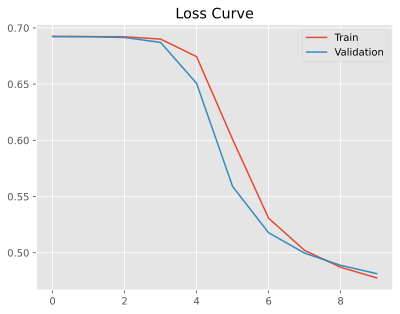

              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83      2265
    Positive       0.81      0.83      0.82      2072

    accuracy                           0.83      4337
   macro avg       0.83      0.83      0.83      4337
weighted avg       0.83      0.83      0.83      4337



In [6]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.title("Loss Curve")
plt.show()

# --- TEST ---
bow_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for _, bow, target, _ in test_loader:
        bow = bow.to(device)
        out = bow_model(bow)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = target.numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))


In [7]:
MODEL_PATH = "bow_text_classifier.pt"

# Save model state and metadata (e.g. vocab)
torch.save({
    "model_state_dict": bow_model.state_dict(),
    "vocab": dataset.token2idx,
    "idx2token": dataset.idx2token
}, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")


Model saved to bow_text_classifier.pt


# Execute from here if you don't want to train the model.

In [ ]:
def load_saved_bow_model(model_path="bow_text_classifier.pt", device=None):
    """
    Load the saved BoW classifier and its vocab metadata.
    Returns: (model, vocab, idx2token)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # load checkpoint (maps tensors to the selected device)
    ckpt = torch.load(model_path, map_location=device)

    # restore vocab / metadata
    vocab = ckpt.get("vocab", None)
    idx2token = ckpt.get("idx2token", None)
    if vocab is None:
        raise ValueError(f"No 'vocab' found in checkpoint {model_path}")
    
    vocab_size = len(vocab)
    model = FeedforwardTextClassifier(
        vocab_size = vocab_size,
        hidden1 = 30,
        hidden2 = 50,
        hidden3 = 100,
        num_labels = 2,
    ).to(device)

    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    print(f"Loaded model from {model_path} (vocab_size={vocab_size}) on {device}")
    return model, vocab, idx2token

bow_model, _, _ = load_saved_bow_model("bow_text_classifier.pt", device=device)

Loaded model from bow_text_classifier.pt (vocab_size=4860) on cpu


# Captum Evaluation

In [9]:
from captum.metrics import infidelity
from captum.attr import IntegratedGradients

bow_model.eval()

# --- PREPARE INPUTS FOR CAPTUM INFIDELITY ---
inputs_list, targets_list = [], []

# Collect a subset of examples (e.g., from test_loader)
for _, bow, target, _ in test_loader:
    inputs_list.append(bow)
    targets_list.append(target)

"""# Optional: limit to the first N batches for speed
inputs_list = inputs_list[:10]
targets_list = targets_list[:10]"""

# Combine inputs & targets from batches
inputs = torch.cat(inputs_list, dim=0).to(device)
targets = torch.cat(targets_list, dim=0).to(device)

# Compute attributions
ig = IntegratedGradients(bow_model)
attributions = ig.attribute(inputs, target=targets)

# Perturbation function
def perturb_fn(x):
    noise = torch.randn_like(x) * 0.01
    return noise, x + noise

# Compute infidelity
inf_value = infidelity(
    forward_func=bow_model,      # your model
    inputs=inputs,
    attributions=attributions,
    perturb_func=partial(perturb_fn),
    target=targets
)

inf_mean = inf_value.mean().item()
inf_median = inf_value.median().item()

print(f"Mean infidelity: {inf_mean:.6f}")
print(f"Median infidelity: {inf_median:.6f}")

Mean infidelity: 0.002233
Median infidelity: 0.000276


In [10]:
# --- PLOT INFIDELITY ---
N = 10
sample_inf = inf_value[:N].detach().cpu().numpy()

# --- TABLE: Tweet, Prediction, True Label ---
preds = []
true_labels = []
texts = []

# Run model to get predictions for same subset
bow_model.eval()
with torch.no_grad():
    for i in range(N):
        bow_vec = inputs[i].unsqueeze(0)  # shape [1, vocab_size]
        output = bow_model(bow_vec)
        pred_label = torch.argmax(output, dim=1).item()
        true_label = targets[i].item()

        texts.append(dataset[i][3])
        preds.append("Positive" if pred_label == 1 else "Negative")
        true_labels.append("Positive" if true_label == 1 else "Negative")

# Create a table
results_df = pd.DataFrame({
    "Tweet": texts,
    "Prediction": preds,
    "True Label": true_labels,
    "Infidelity": sample_inf
})

# Truncate long tweets for readability
pd.set_option('display.max_colwidth', 100)

display(results_df)

,Tweet,Prediction,True Label,Infidelity
0,"im getting on borderlands and i will murder you all ,",Negative,Negative,0.006173
1,"I am coming to the borders and I will kill you all,",Negative,Negative,0.000004
2,"im getting on borderlands and i will kill you all,",Positive,Positive,0.012211
3,"im coming on borderlands and i will murder you all,",Negative,Negative,0.000049
4,"im getting on borderlands 2 and i will murder you me all,",Negative,Positive,0.005055
5,"im getting into borderlands and i can murder you all,",Positive,Negative,0.000351
6,So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands ...,Positive,Positive,0.000004
7,So I spent a couple of hours doing something for fun... If you don't know that I'm a huge @ Bord...,Negative,Positive,0.000033
8,So I spent a few hours doing something for fun... If you don't know I'm a HUGE @ Borderlands fan...,Negative,Negative,0.000005
9,So I spent a few hours making something for fun. . . If you don't know I am a HUGE RhandlerR fan...,Negative,Negative,0.000214
